In [1]:
import math
import itertools
from collections.abc import Iterable, Collection
from numbers import Number

import numpy as np

%matplotlib widget
import matplotlib
import matplotlib.axes
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
image_width = 320
image_height = 240

In [3]:
camera_f = 3.04 * 1e-3 # 3.04 mm
sensor_width = 3.68 * 1e-3 # 3.68 mm
sensor_height = 2.76 * 1e-3 # 2.76 mm

In [4]:
def get_camera_intrinsic(camera_f, sensor_width, sensor_height, image_width, image_height):
    image_center_x = image_width / 2 
    image_center_y = image_height / 2
    
    intrinsic = np.array([[camera_f * image_width / sensor_width, 0.0, image_center_x],
                          [0.0, camera_f * image_height / sensor_height, image_center_y],
                          [0.0, 0.0, 1.0]])
    
    return intrinsic

In [5]:
camera_intrinsics = get_camera_intrinsic(camera_f, sensor_width, sensor_height, image_width, image_height)

In [6]:
camera_intrinsics

array([[264.34782609,   0.        , 160.        ],
       [  0.        , 264.34782609, 120.        ],
       [  0.        ,   0.        ,   1.        ]])

In [7]:
camera_intrinsics_inv = np.linalg.inv(camera_intrinsics)

In [8]:
camera_intrinsics_inv

array([[ 0.00378289,  0.        , -0.60526316],
       [ 0.        ,  0.00378289, -0.45394737],
       [ 0.        ,  0.        ,  1.        ]])

In [9]:
def to_homogeneous(vector):
    return np.concatenate([vector, np.ones((len(vector), 1))], axis=-1)

In [10]:
def circular_pair_generator(collection: Collection):
    n = len(collection)
    for i in range(n):
        yield collection[i], collection[ (i + 1) % n ]

In [11]:
origin = np.array([-0.01,0,0])
# camera_axis = np.array([[1,0,0], [0,1,0], [0,0,1]]).T
# camera_axis = np.array([[0,1,0], [-1,0,0], [0,0,1]]).T
camera_axis = np.array([[0,-1,0], [0,0,1], [-1,0,0]]).T

camera_frame = np.eye(4,4,dtype=np.float32)
camera_frame[:3, :3] = camera_axis
camera_frame[:3, 3] = origin

camera_frame_inv = np.linalg.inv(camera_frame)

In [12]:
camera_frame_inv

array([[ 0.  ,  1.  ,  0.  ,  0.  ],
       [-1.  , -0.  , -0.  , -0.01],
       [ 0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ]], dtype=float32)

In [13]:
camera_intrinsics_inv.T

array([[ 0.00378289,  0.        ,  0.        ],
       [ 0.        ,  0.00378289,  0.        ],
       [-0.60526316, -0.45394737,  1.        ]])

In [14]:
def pixels_to_world_point(camera_extrinsics, camera_intrinsics_inv, pixel_points, projection_distance):
    # pixel_points in homogeneous coordinate
    
    # Pixel to Image Plane
    image_plane_points = pixel_points @ camera_intrinsics_inv.T
    image_plane_points *= projection_distance

    # Image Plane to World
    image_plane_points_homogeneous = to_homogeneous(image_plane_points)
    world_points = image_plane_points_homogeneous @ camera_extrinsics.T

    world_points /= world_points[..., -1]
    
    return world_points

In [15]:
def get_image_plane_polygon(camera_frame, image_width, image_height, camera_intrinsics_inv: np.ndarray, camera_f: Number):
    # Left Top first then cw 
    pixel_vectors = np.array([[0,0,1], [image_width, 0, 1], [image_width, image_height, 1], [0, image_height, 1]], dtype=np.float32)
    world_vectors = pixels_to_world_point(camera_frame, camera_intrinsics_inv, pixel_vectors, camera_f)
    
    return world_vectors

In [16]:
image_plane_polygon = get_image_plane_polygon(camera_frame, image_width, image_height, camera_intrinsics_inv, camera_f)

In [17]:
image_plane_polygon

array([[-0.00862, -0.00184,  0.00304,  1.     ],
       [-0.00862,  0.00184,  0.00304,  1.     ],
       [-0.01138,  0.00184,  0.00304,  1.     ],
       [-0.01138, -0.00184,  0.00304,  1.     ]])

In [18]:
def bounding_polygon_to_inward_planes(bounding_polygon: np.ndarray, camera_intrinsics_inv: np.ndarray, camera_f: Number, camera_extrinsics: np.ndarray):
    # List of points [[x0, y0], [x1, y1], ...]
    # N x 2

    # N x 4
    bounding_point_vectors_homogeneous = pixels_to_world_point(camera_extrinsics, camera_intrinsics_inv, bounding_polygon, camera_f)

    # N x 3
    bounding_point_vectors = np.divide(bounding_point_vectors_homogeneous[:, :-1], bounding_point_vectors_homogeneous[:, [-1]])

    # Transform to planes
    camera_center = camera_intrinsics[:3, 3]

    edge_vector = np.roll(bounding_point_vectors, -1, axis=0) - bounding_point_vectors
    camera_center_to_corner = bounding_point_vectors - camera_center

    inward_planes_normal = np.cross(edge_vector, camera_center_to_corner)
    
    # N x 3
    inward_planes_normal_unit = np.divide(inward_planes_normal, np.linalg.norm(inward_planes_normal, axis=-1, keepdims=True))

    plane_d = np.sum(np.multiply(inward_planes_normal_unit, bounding_point_vectors), axis=-1)

    return inward_planes_normal_unit, plane_d

In [19]:
def format_axes(ax: matplotlib.axes.Axes, suffix='', x_bounds = None, y_bounds = None , z_bounds = None):

    # Axis Labels
    if len(suffix.strip()) != 0:
        suffix = ' ' + suffix
    
    ax.set_xlabel(f'x{suffix}')
    ax.set_ylabel(f'y{suffix}')
    ax.set_zlabel(f'z{suffix}')

    # Axis bounds
    ax.axis('equal')

    if x_bounds is not None:
        ax.set_xlim(*x_bounds)

    if y_bounds is not None:
        ax.set_ylim(*y_bounds)
        
    if z_bounds is not None:
        ax.set_zlim(*z_bounds)

    


In [20]:
def plot_frame(ax, frame):
    axis_color = [(1.0, 0.0, 0.0), (0.0, 1.0, 0.0), (0.0, 0.0, 1.0)]

    origin = frame[:3, 3]

    origins = np.tile(origin, (3,1))

    print(origins)

    # Axis direction
    ax.quiver(origins[:, 0], origins[:, 1], origins[:, 2], frame[0, :-1], frame[1, :-1], frame[2, :-1], color=axis_color)

    # Origin
    ax.scatter([origin[0]], [origin[1]], origin[2], color=[(0.0, 0.0, 0.0)])

    return ax

In [21]:
def plot_polygon(ax: matplotlib.axes.Axes, polygon: np.ndarray, face_color=None, alpha=1.0, vertices_color=None):
    # polygon: N x 3

    vertices = [list(zip(polygon[:, 0], polygon[:, 1], polygon[:, 2]))]

    polygon_collection = Poly3DCollection(vertices, linewidths=1, alpha=0.2)

    if face_color is not None:
        polygon_collection.set_facecolor(face_color)

    ax.add_collection3d(polygon_collection)

    ax.scatter(polygon[:, 0], polygon[:, 1], polygon[:, 2], c = vertices_color)

    return ax

In [22]:
cmap = plt.get_cmap('Set3')
sequence_color = [ cmap(i) for i in range(cmap.N) ]

[[-0.01  0.    0.  ]
 [-0.01  0.    0.  ]
 [-0.01  0.    0.  ]]


<Axes3D: >

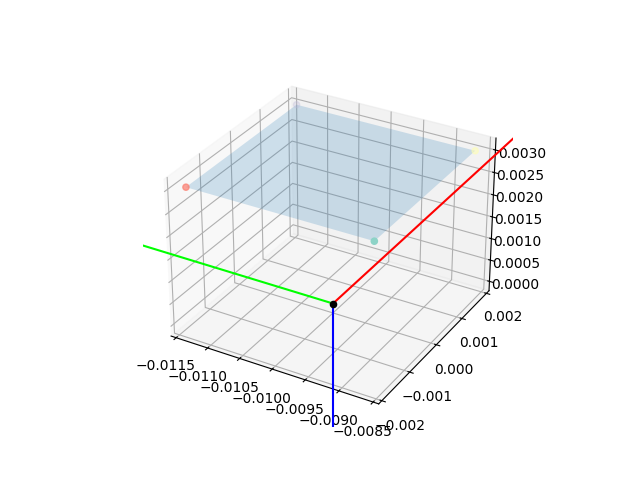

In [29]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(projection='3d')

plot_frame(ax1, camera_frame)

plot_polygon(ax1, image_plane_polygon, vertices_color=sequence_color[:4])

# for i, poly in enumerate(plane_polygons):
#     plot_polygon(ax1, poly, face_color=sequence_color[i])


# format_axes(ax1, suffix='(m)', x_bounds=[-0.5, 0.5], y_bounds=[-0.5, 0.5], z_bounds=[-0.5, 0.5])

# ax1.set_xlim(-0.01, 0.01)
# ax1.set_ylim(-0.01, 0.01)
# ax1.set_zlim(-0.01, 0.01)

In [24]:
image_plane_polygon

array([[-0.00862, -0.00184,  0.00304,  1.     ],
       [-0.00862,  0.00184,  0.00304,  1.     ],
       [-0.01138,  0.00184,  0.00304,  1.     ],
       [-0.01138, -0.00184,  0.00304,  1.     ]])

In [25]:
image_plane_vectors = np.array([[0,0], [image_width, 0], [image_width, image_height], [0, image_height]], dtype=np.float32)

In [26]:
planes_n, planes_d = bounding_polygon_to_inward_planes(to_homogeneous(image_plane_vectors), camera_intrinsics_inv, camera_f, camera_frame)

IndexError: index 3 is out of bounds for axis 1 with size 3

In [119]:
planes_n

array([[ 0.        , -0.85550008, -0.51780268],
       [ 0.33259121,  0.        ,  0.94307109],
       [ 0.        ,  0.85550008, -0.51780268],
       [-0.25808535,  0.        , -0.96612212]])

In [120]:
planes_d

array([6.50521303e-19, 0.00000000e+00, 6.50521303e-19, 0.00000000e+00])

In [121]:
plane_x_bounds = np.array([-0.005, 0.005])
plane_y_bounds = np.array([-0.005, 0.005])
plane_z_bounds = np.array([-0.005, 0.005])


In [122]:
def plane_to_polygon(planes_n, planes_d, x_bounds, y_bounds, z_bounds):
    # plane_n N x 3
    # plane_d N x 
    planes_d_expanded = np.expand_dims(planes_d, -1)

    max_index = np.argmax(np.abs(planes_n), axis=-1)

    corner_pair_orient = np.array([0,1,3,2])

    # 1 x (2*2) x 2
    xy_pair = np.stack(np.meshgrid(x_bounds, y_bounds), axis=-1).reshape(1, -1, 2)[:,corner_pair_orient]
    yz_pair = np.stack(np.meshgrid(y_bounds, z_bounds), axis=-1).reshape(1, -1, 2)[:,corner_pair_orient]
    zx_pair = np.stack(np.meshgrid(z_bounds, x_bounds), axis=-1).reshape(1, -1, 2)[:,corner_pair_orient]

    # N x (2x2)
    solve_z = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [0,1]], 1), xy_pair), axis=-1), np.expand_dims(planes_n[:, 2], -1))
    solve_x = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [1,2]], 1), yz_pair), axis=-1), np.expand_dims(planes_n[:, 0], -1))
    solve_y = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [2,0]], 1), zx_pair), axis=-1), np.expand_dims(planes_n[:, 1], -1))

    # N x (2x2) x 3
    solve_z_corner_points = np.concatenate([np.tile(xy_pair, (len(planes_n), 1, 1)), np.expand_dims(solve_z, -1)], -1)
    solve_x_corner_points = np.roll(np.concatenate([np.tile(yz_pair, (len(planes_n), 1, 1)), np.expand_dims(solve_x, -1)], -1), 1, -1)
    solve_y_corner_points = np.roll(np.concatenate([np.tile(zx_pair, (len(planes_n), 1, 1)), np.expand_dims(solve_y, -1)], -1), -1, -1)

    solve_corner_points = np.stack([solve_x_corner_points, solve_y_corner_points, solve_z_corner_points], axis=1)

    return solve_corner_points[np.arange(len(planes_n)), max_index, ...]

In [123]:
plane_polygons = plane_to_polygon(planes_n, planes_d, plane_x_bounds, plane_y_bounds, plane_z_bounds)

/tmp/ipykernel_1298192/1560192500.py:17: RuntimeWarning: divide by zero encountered in divide
  solve_x = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [1,2]], 1), yz_pair), axis=-1), np.expand_dims(planes_n[:, 0], -1))
/tmp/ipykernel_1298192/1560192500.py:18: RuntimeWarning: divide by zero encountered in divide
  solve_y = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [2,0]], 1), zx_pair), axis=-1), np.expand_dims(planes_n[:, 1], -1))


In [124]:
plane_polygons

array([[[-0.005     ,  0.00302632, -0.005     ],
        [-0.005     , -0.00302632,  0.005     ],
        [ 0.005     , -0.00302632,  0.005     ],
        [ 0.005     ,  0.00302632, -0.005     ]],

       [[-0.005     , -0.005     ,  0.00176334],
        [ 0.005     , -0.005     , -0.00176334],
        [ 0.005     ,  0.005     , -0.00176334],
        [-0.005     ,  0.005     ,  0.00176334]],

       [[-0.005     , -0.00302632, -0.005     ],
        [-0.005     ,  0.00302632,  0.005     ],
        [ 0.005     ,  0.00302632,  0.005     ],
        [ 0.005     , -0.00302632, -0.005     ]],

       [[-0.005     , -0.005     ,  0.00133568],
        [ 0.005     , -0.005     , -0.00133568],
        [ 0.005     ,  0.005     , -0.00133568],
        [-0.005     ,  0.005     ,  0.00133568]]])

[[-0.01  0.    0.  ]
 [-0.01  0.    0.  ]
 [-0.01  0.    0.  ]]


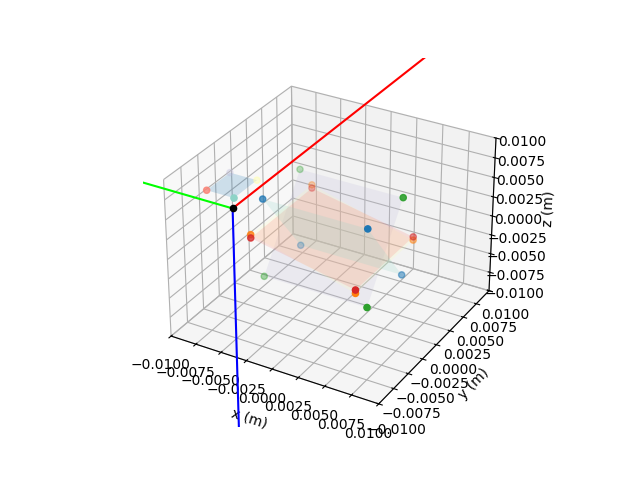

In [125]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(projection='3d')

plot_frame(ax2, camera_frame)

plot_polygon(ax2, image_plane_polygon, vertices_color=sequence_color[:4])

for i, poly in enumerate(plane_polygons):
    plot_polygon(ax2, poly, face_color=sequence_color[i])


format_axes(ax2, suffix='(m)', x_bounds=[-0.01, 0.01], y_bounds=[-0.01, 0.01], z_bounds=[-0.01, 0.01])

# ax1.set_xlim(-0.01, 0.01)
# ax1.set_ylim(-0.01, 0.01)
# ax1.set_zlim(-0.01, 0.01)

In [34]:
def generate_sphere(radius, theta_count, phi_count):

    theta = np.linspace(-np.pi, np.pi, theta_count)
    phi = np.linspace(-np.pi, np.pi, phi_count)

    theta_grid, phi_grid = np.meshgrid(theta, phi)

    z = radius*np.cos(phi_grid)
    xy_projection = radius*np.sin(phi_grid)
    x = np.cos(theta_grid) * xy_projection
    y = np.sin(theta_grid) * xy_projection

    return np.stack([x,y,z], axis=-1).reshape(-1, 3)





In [45]:
sphere_points_1 = generate_sphere(0.2,30,30)

In [46]:
sphere_points_1.shape

(900, 3)

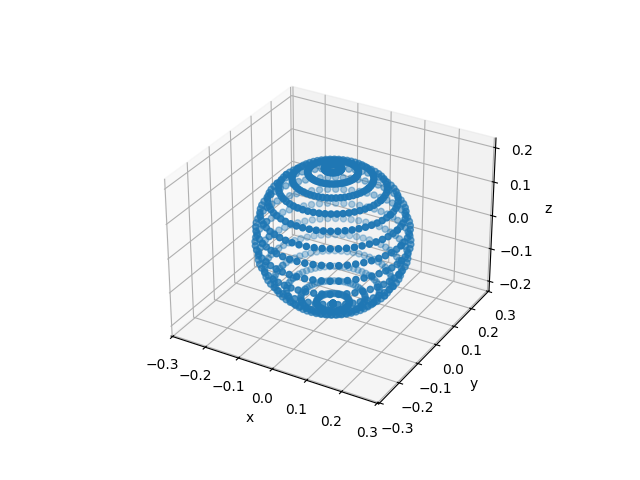

In [47]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')

ax3.scatter(sphere_points_1[:,0], sphere_points_1[:,1], sphere_points_1[:,2])

format_axes(ax3)

In [48]:
def get_plane_side_mask(points, planes_n, planes_d, same_side_as_normal:bool = True, on_plane_valid : bool = True):
    # Points N x 3

    # Use loops to reduce computation
    # Vectorize use a lot of memory

    candidate_indices = np.arange(len(points))
    candidate_points = points

    for n, d in zip(planes_n, planes_d):
        normal_dot = np.sum(np.multiply(candidate_points, np.expand_dims(n, 0)), axis=-1) - d

        candidate_mask = normal_dot > 0 if same_side_as_normal else normal_dot < 0
        candidate_mask = candidate_mask if not on_plane_valid else np.logical_or(normal_dot == 0, candidate_mask)

        candidate_points = candidate_points[candidate_mask]
        candidate_indices = candidate_indices[candidate_mask]

    mask = np.zeros(len(points), dtype=bool)
    mask[candidate_indices] = True
    return mask

In [49]:
sphere_points_1_mask = get_plane_side_mask(sphere_points_1, planes_n, planes_d)

/tmp/ipykernel_1245721/1560192500.py:17: RuntimeWarning: divide by zero encountered in divide
  solve_x = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [1,2]], 1), yz_pair), axis=-1), np.expand_dims(planes_n[:, 0], -1))
/tmp/ipykernel_1245721/1560192500.py:18: RuntimeWarning: divide by zero encountered in divide
  solve_y = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [2,0]], 1), zx_pair), axis=-1), np.expand_dims(planes_n[:, 1], -1))


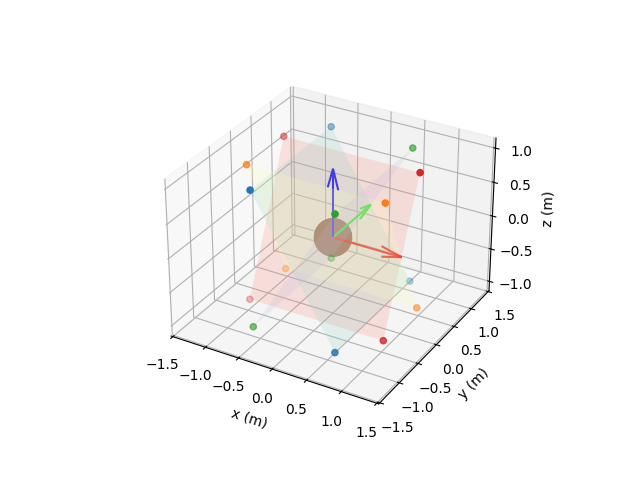

In [50]:
fig4 = plt.figure()
ax4 = fig4.add_subplot(projection='3d')

plot_frame(ax4, camera_frame)

plot_polygon(ax4, image_plane_polygon, vertices_color=sequence_color[:4])

for i, poly in enumerate(plane_to_polygon(planes_n, planes_d, np.array([-1, 1]), np.array([-1, 1]), np.array([-1, 1]))):
    plot_polygon(ax4, poly, face_color=sequence_color[i])

# in points
sphere_points_1_in = sphere_points_1[sphere_points_1_mask] 
sphere_points_1_out = sphere_points_1[np.logical_not(sphere_points_1_mask)]

ax4.scatter(sphere_points_1_in[:,0], sphere_points_1_in[:,1], sphere_points_1_in[:,2])
ax4.scatter(sphere_points_1_out[:,0], sphere_points_1_out[:,1], sphere_points_1_out[:,2])

format_axes(ax4, suffix='(m)')

In [41]:
sphere_points_2 = generate_sphere(2,30,30)
sphere_points_3 = generate_sphere(5,30,30)
sphere_points_4 = generate_sphere(10,30,30)

In [42]:
spheres = [sphere_points_1, sphere_points_2, sphere_points_3, sphere_points_4]

In [43]:
sphere_masks = [ get_plane_side_mask(s, planes_n, planes_d) for s in spheres ]

/tmp/ipykernel_1245721/1560192500.py:17: RuntimeWarning: divide by zero encountered in divide
  solve_x = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [1,2]], 1), yz_pair), axis=-1), np.expand_dims(planes_n[:, 0], -1))
/tmp/ipykernel_1245721/1560192500.py:18: RuntimeWarning: divide by zero encountered in divide
  solve_y = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [2,0]], 1), zx_pair), axis=-1), np.expand_dims(planes_n[:, 1], -1))
/tmp/ipykernel_1245721/80076878.py:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax5.scatter(sphere_points_in[:,0], sphere_points_in[:,1], sphere_points_in[:,2], c=in_color)
/tmp/ipykernel_1245721/80076878.py:2

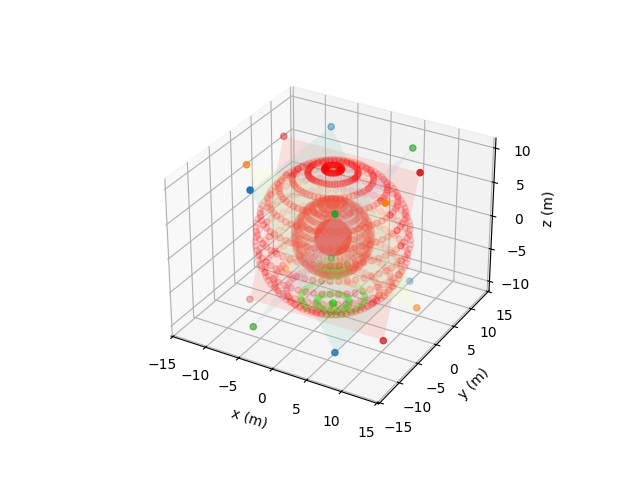

In [44]:
fig5 = plt.figure()
ax5 = fig5.add_subplot(projection='3d')

plot_frame(ax5, camera_frame)

plot_polygon(ax5, image_plane_polygon, vertices_color=sequence_color[:4])

for i, poly in enumerate(plane_to_polygon(planes_n, planes_d, np.array([-10, 10]), np.array([-10, 10]), np.array([-10, 10]))):
    plot_polygon(ax5, poly, face_color=sequence_color[i])

in_color = (0.0, 1.0, 0.0, 0.2)
out_color = (1.0, 0.0, 0.0, 0.2)

# in points
for sphere, sphere_mask in zip(spheres, sphere_masks):
    sphere_points_in = sphere[sphere_mask] 
    sphere_points_out = sphere[np.logical_not(sphere_mask)]

    ax5.scatter(sphere_points_in[:,0], sphere_points_in[:,1], sphere_points_in[:,2], c=in_color)
    ax5.scatter(sphere_points_out[:,0], sphere_points_out[:,1], sphere_points_out[:,2], c=out_color)

format_axes(ax5, suffix='(m)')

In [52]:
bounding_box_vector = np.array([[111,69], [184, 69], [184, 142], [111, 142]], dtype=np.float32)

In [58]:
bounding_box_vector_world = pixels_to_world_point(camera_frame, camera_intrinsics_inv, to_homogeneous(bounding_box_vector), 0.6)

In [59]:
bounding_box_vector_world

array([[-0.11121711, -0.11575658,  0.6       ,  1.        ],
       [ 0.05447368, -0.11575658,  0.6       ,  1.        ],
       [ 0.05447368,  0.04993421,  0.6       ,  1.        ],
       [-0.11121711,  0.04993421,  0.6       ,  1.        ]])

In [53]:
bounding_box_planes_n, bounding_box_planes_d = bounding_polygon_to_inward_planes(to_homogeneous(bounding_box_vector), camera_intrinsics_inv, camera_f, camera_frame)

In [60]:
bounding_box_planes_n

array([[-0.98325089,  0.        , -0.1822572 ],
       [ 0.        , -0.98189339, -0.18943437],
       [ 0.99590394,  0.        , -0.09041759],
       [ 0.        ,  0.9965548 , -0.08293696]])

In [61]:
bounding_box_planes_polygon = plane_to_polygon(bounding_box_planes_n, bounding_box_planes_d, np.array([-1.0, 1.0]), np.array([-1.0, 1.0]), np.array([-0.5, 1.0]))

/tmp/ipykernel_1245721/1560192500.py:17: RuntimeWarning: divide by zero encountered in divide
  solve_x = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [1,2]], 1), yz_pair), axis=-1), np.expand_dims(planes_n[:, 0], -1))
/tmp/ipykernel_1245721/1560192500.py:18: RuntimeWarning: divide by zero encountered in divide
  solve_y = np.divide(planes_d_expanded - np.sum(np.multiply(np.expand_dims(planes_n[:, [2,0]], 1), zx_pair), axis=-1), np.expand_dims(planes_n[:, 1], -1))


In [63]:
bounding_box_planes_polygon

array([[[ 0.09268092, -1.        , -0.5       ],
        [ 0.09268092,  1.        , -0.5       ],
        [-0.18536184,  1.        ,  1.        ],
        [-0.18536184, -1.        ,  1.        ]],

       [[-1.        ,  0.09646382, -0.5       ],
        [-1.        , -0.19292763,  1.        ],
        [ 1.        , -0.19292763,  1.        ],
        [ 1.        ,  0.09646382, -0.5       ]],

       [[-0.04539474, -1.        , -0.5       ],
        [-0.04539474,  1.        , -0.5       ],
        [ 0.09078947,  1.        ,  1.        ],
        [ 0.09078947, -1.        ,  1.        ]],

       [[-1.        , -0.04161184, -0.5       ],
        [-1.        ,  0.08322368,  1.        ],
        [ 1.        ,  0.08322368,  1.        ],
        [ 1.        , -0.04161184, -0.5       ]]])

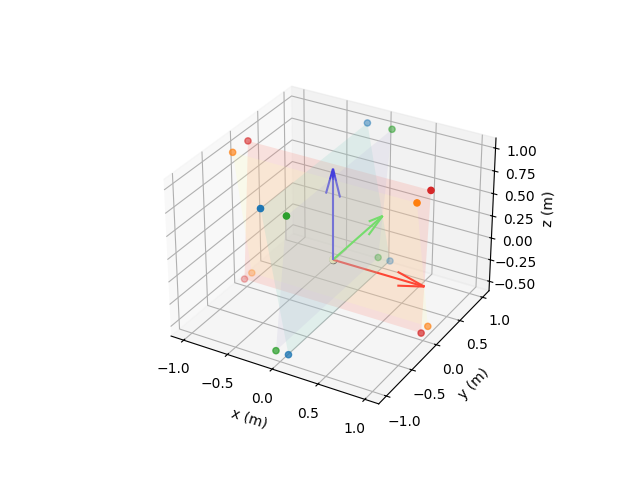

In [62]:
fig6 = plt.figure()
ax6 = fig6.add_subplot(projection='3d')

plot_frame(ax6, camera_frame)

plot_polygon(ax6, image_plane_polygon, vertices_color=sequence_color[:4])

for i, poly in enumerate(bounding_box_planes_polygon):
    plot_polygon(ax6, poly, face_color=sequence_color[i])

# in_color = (0.0, 1.0, 0.0, 0.2)
# out_color = (1.0, 0.0, 0.0, 0.2)

# # in points
# for sphere, sphere_mask in zip(spheres, sphere_masks):
#     sphere_points_in = sphere[sphere_mask] 
#     sphere_points_out = sphere[np.logical_not(sphere_mask)]

#     ax6.scatter(sphere_points_in[:,0], sphere_points_in[:,1], sphere_points_in[:,2], c=in_color)
#     ax6.scatter(sphere_points_out[:,0], sphere_points_out[:,1], sphere_points_out[:,2], c=out_color)

format_axes(ax6, suffix='(m)')